# Name: Balakrishna Mupparaju
# Assignment : Project Final Milestone

In [4]:
#2.1 Load, Inspect, and Deduplicate
import pandas as pd

# Load dataset
df = pd.read_csv("/Users/balakrishnamupparaju/Downloads/insurance.csv")

# Drop exact duplicates
initial_count = len(df)
df.drop_duplicates(inplace=True)
dropped = initial_count - len(df)
print(f"Dropped {dropped} duplicate rows")

# Inspect structure
print(df.info())
print(df.head())


Dropped 1 duplicate rows
<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB
None
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [12]:
# Check for missing values
missing = df.isna().sum()
print("Missing values per column:\n", missing)


Missing values per column:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [14]:

#2.3 Target Engineering: Log Transformation
import numpy as np

# Stabilize variance with log1p
df["log_charges"] = np.log1p(df["charges"])


In [16]:
#2.4 High-Cost Label Creation

# Top 10% threshold
threshold = df["charges"].quantile(0.90)
df["high_cost"] = (df["charges"] >= threshold).astype(int)

print(f"High-cost threshold: ${threshold:.2f}")
print(df["high_cost"].value_counts())


High-cost threshold: $34832.74
high_cost
0    1203
1     134
Name: count, dtype: int64


In [51]:
#2.5 Train/Test Split

from sklearn.model_selection import train_test_split

features = ["age", "sex", "bmi", "children", "smoker", "region"]
X = df[features]
y_reg = df["log_charges"]
y_clf = df["high_cost"]

X_train,X_test,y_reg_train, \
y_reg_test,y_clf_train,y_clf_test=train_test_split(
    X, y_reg, y_clf,
    test_size=0.20,
    stratify=y_clf,
    random_state=42
)


In [20]:
#2.6 Preprocessing Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_feats     = ["age", "bmi", "children"]
categorical_feats = ["sex", "smoker", "region"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(drop="first"), categorical_feats)
])


In [30]:
#3.1 Baseline Linear Regression

from sklearn.linear_model import LinearRegression

pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("lr", LinearRegression())
])

pipe_lr.fit(X_train, y_reg_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lr', LinearRegression())])

In [34]:
#3.2 Tuned Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])

param_grid = {
    "rf__n_estimators":      [100, 300, 500],
    "rf__max_depth":         [None, 10, 20],
    "rf__max_features":      ["sqrt", 0.25, None],
    "rf__min_samples_split": [2, 5]
}

grid_rf = GridSearchCV(
    pipe_rf, param_grid,
    cv=5, scoring="neg_mean_squared_error",
    n_jobs=-1, verbose=1
)
grid_rf.fit(X_train, y_reg_train)
best_rf = grid_rf.best_estimator_
print("Best RF params:", grid_rf.best_params_)





Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best RF params: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 500}


In [19]:
#4. Regression Evaluation & Diagnostics
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_reg(model, X_te, y_te_log):
    y_pred_log = model.predict(X_te)
    rmse_log   = np.sqrt(mean_squared_error(y_te_log, y_pred_log))
    r2_log     = r2_score(y_te_log, y_pred_log)
    
    y_true_dol = np.expm1(y_te_log)
    y_pred_dol = np.expm1(y_pred_log)
    rmse_dol   = np.sqrt(mean_squared_error(y_true_dol, y_pred_dol))
    r2_dol     = r2_score(y_true_dol, y_pred_dol)
    
    return rmse_log, r2_log, rmse_dol, r2_dol

metrics_lr = evaluate_reg(pipe_lr, X_test, y_reg_test)
metrics_rf = evaluate_reg(best_rf, X_test, y_reg_test)

print("Linear Regression  (log RMSE, log R², $ RMSE, $ R²):", metrics_lr)
print("Random Forest      (log RMSE, log R², $ RMSE, $ R²):", metrics_rf)


Linear Regression  (log RMSE, log R², $ RMSE, $ R²): (0.4737345366069822, 0.7305144388350735, 8108.30323318041, 0.5629848312678458)
Random Forest      (log RMSE, log R², $ RMSE, $ R²): (0.4333490423209053, 0.7745028336278132, 5817.032346606407, 0.7750740802386593)


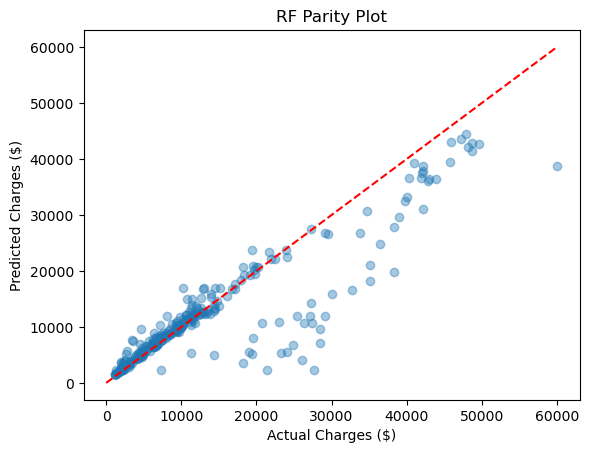

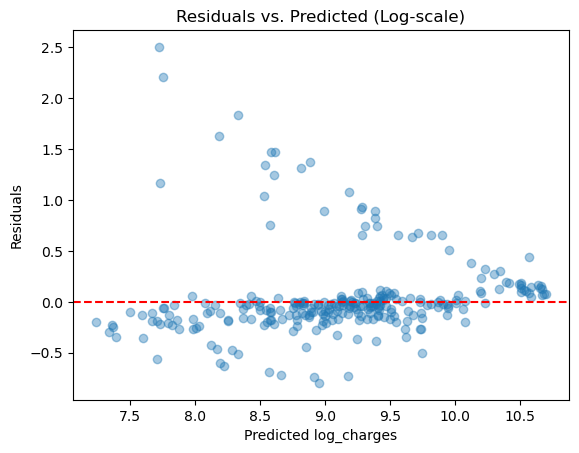

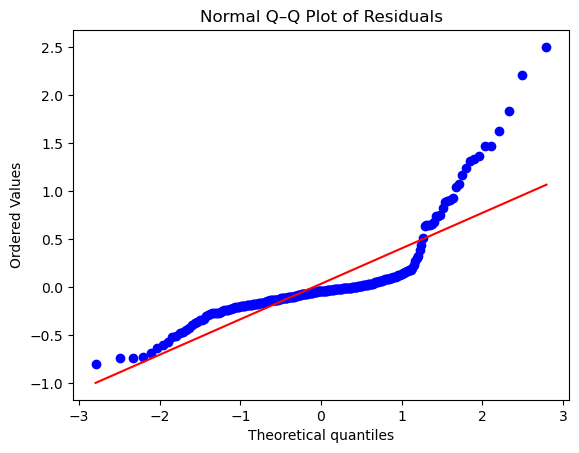

In [38]:
#4.2 Diagnostic Plotsimport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Parity Plot
y_true = np.expm1(y_reg_test)
y_pred = np.expm1(best_rf.predict(X_test))
plt.scatter(y_true, y_pred, alpha=0.4)
lims = [0, max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("Actual Charges ($)")
plt.ylabel("Predicted Charges ($)")
plt.title("RF Parity Plot")
plt.show()

# Residuals vs. Predicted (log-scale)
resid = y_reg_test - best_rf.predict(X_test)
plt.scatter(best_rf.predict(X_test), resid, alpha=0.4)
plt.axhline(0, color="red", ls="--")
plt.xlabel("Predicted log_charges")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (Log-scale)")
plt.show()

# Q–Q Plot
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q–Q Plot of Residuals")
plt.show()



In [40]:
#5.1 Model Training & Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

pipe_clf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid_clf = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth":    [None, 10],
    "clf__class_weight": ["balanced", None]
}

grid_clf = GridSearchCV(
    pipe_clf, param_grid_clf,
    cv=5, scoring="precision",
    n_jobs=-1, verbose=1
)
grid_clf.fit(X_train, y_clf_train)

best_clf = grid_clf.best_estimator_
print("Best Classifier params:", grid_clf.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Classifier params: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__n_estimators': 100}


              precision    recall  f1-score   support

           0      0.980     1.000     0.990       241
           1      1.000     0.815     0.898        27

    accuracy                          0.981       268
   macro avg      0.990     0.907     0.944       268
weighted avg      0.982     0.981     0.980       268

ROC AUC: 0.9864761026586754


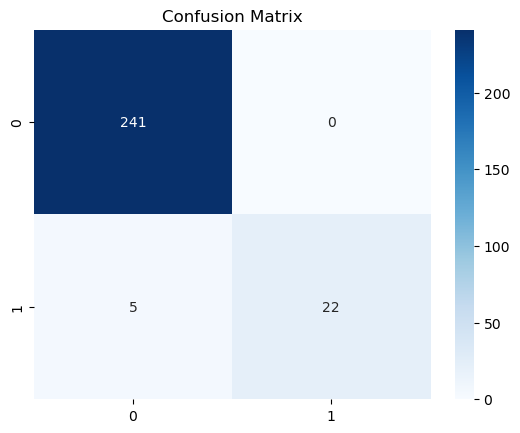

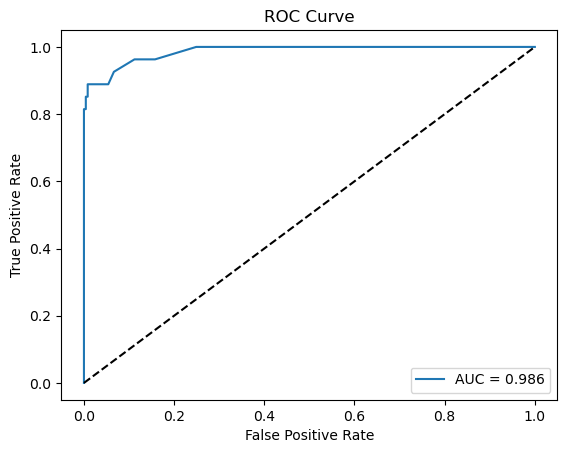

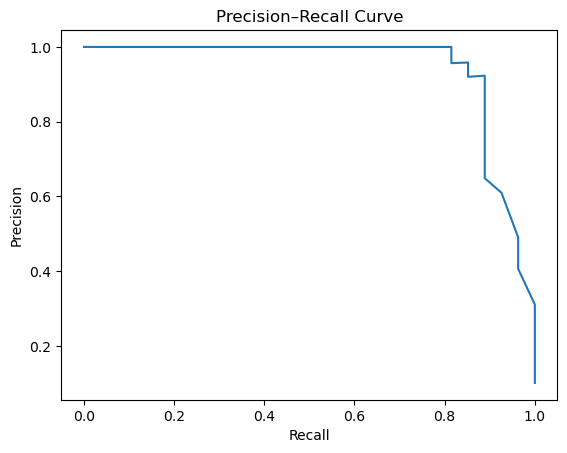

In [42]:
#5.2 Performance Evaluation
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
# Predictions
y_pred_cls  = best_clf.predict(X_test)
y_proba_cls = best_clf.predict_proba(X_test)[:,1]

# Classification report
print(classification_report(y_clf_test, y_pred_cls, digits=3))
print("ROC AUC:", roc_auc_score(y_clf_test, y_proba_cls))

# Confusion Matrix
cm = confusion_matrix(y_clf_test, y_pred_cls)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_clf_test, y_proba_cls)
plt.plot(fpr,tpr,label=f"AUC = {roc_auc_score(y_clf_test,y_proba_cls):.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_clf_test, y_proba_cls)
plt.plot(rec, prec, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


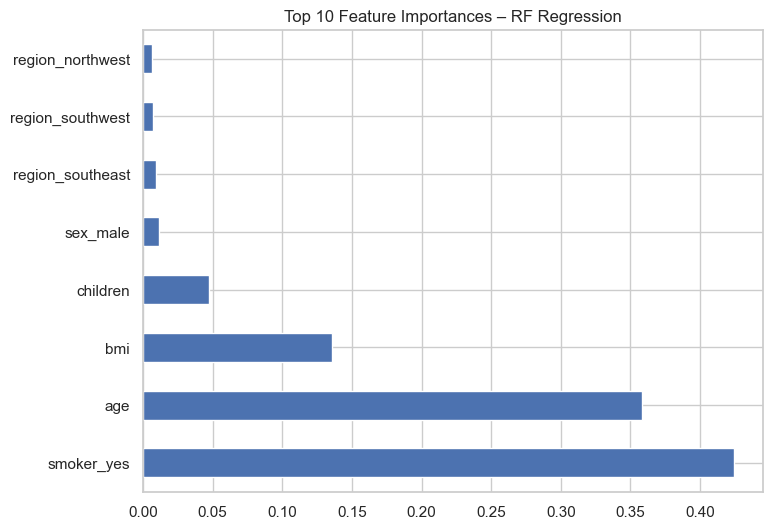

In [28]:
#6.1 Feature Importance (Regression)
import pandas as pd
import matplotlib.pyplot as plt

importances = best_rf.named_steps["rf"].feature_importances_
feat_names = numeric_feats + list(preprocessor.named_transformers_["cat"]
                                  .get_feature_names_out(categorical_feats))
feat_imp    = pd.Series(importances, index=feat_names).nlargest(10)

feat_imp.plot.barh()
plt.title("Top 10 Feature Importances – RF Regression")
plt.show()


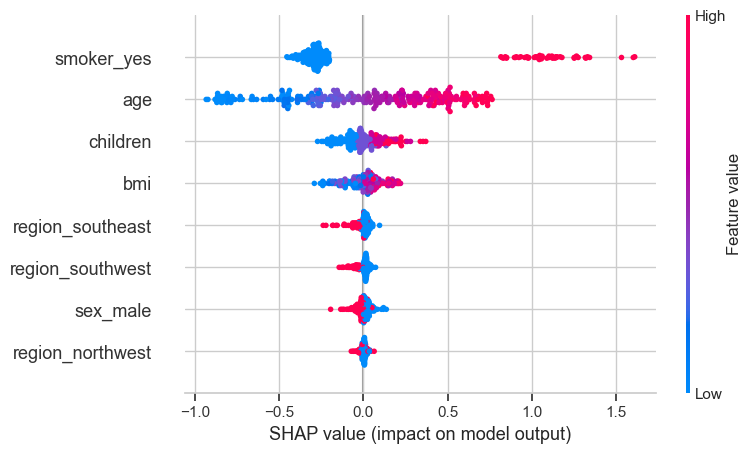

In [30]:
#6.2 SHAP Analysis
import shap

# Prepare scaled features
X_test_scaled = preprocessor.transform(X_test)

# SHAP explainer and values
explainer_rf = shap.TreeExplainer(best_rf.named_steps["rf"])
shap_vals_rf = explainer_rf.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(
    shap_vals_rf,
    X_test_scaled,
    feature_names=feat_names
)


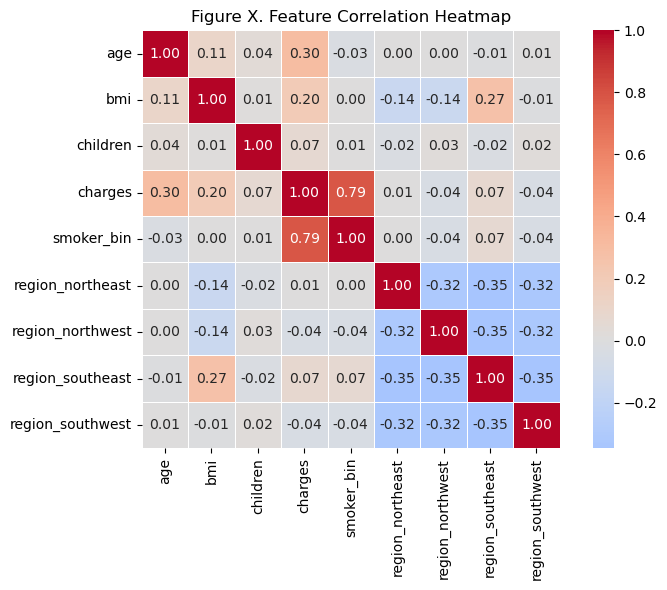

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Compute correlations on numeric-only or encoded DataFrame
#    If you still have categorical columns, drop or encode them first:
#    df_model = preprocessor.fit_transform(df)  # if you want numeric array
#    df_corr = pd.DataFrame(df_model, columns=feature_names).corr()

# Or, more simply for original numeric + binary columns:
df_corr = df[['age', 'bmi', 'children', 'charges']].copy()

# If 'smoker' is 'yes'/'no', convert to binary
df_corr['smoker_bin'] = df['smoker'].map({'yes': 1, 'no': 0})

# If you one-hot encoded region, pick one dummy (or include all)
region_dummies = pd.get_dummies(df['region'], prefix='region')
df_corr = pd.concat([df_corr, region_dummies], axis=1)

# 2. Calculate correlation matrix
corr_matrix = df_corr.corr()

# 3. Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=.5
)
plt.title('Figure X. Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


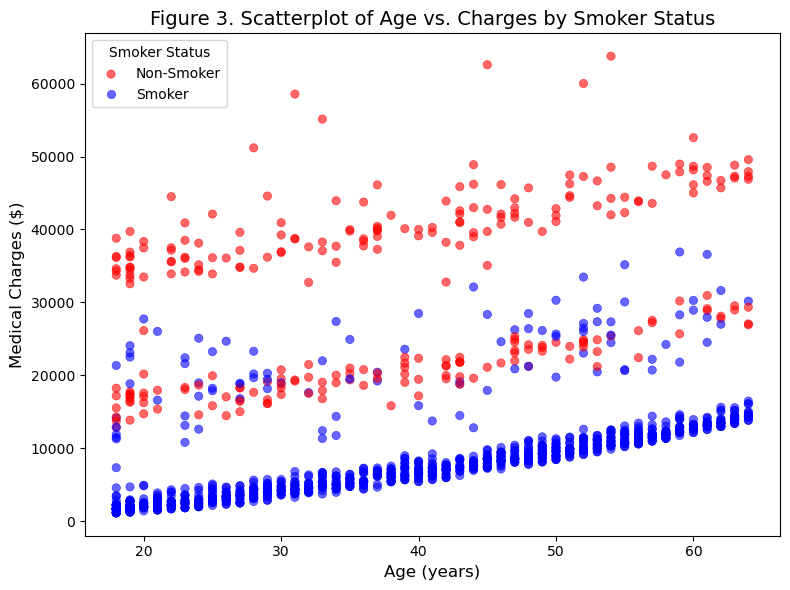

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define color mapping and order
palette = {'no': 'blue', 'yes': 'red'}
hue_order = ['no', 'yes']  # ensures non-smoker appears first

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='age',
    y='charges',
    hue='smoker',
    palette=palette,
    hue_order=hue_order,
    alpha=0.6,
    edgecolor=None
)

# Fix legend title and labels
plt.legend(
    title='Smoker Status',
    labels=['Non-Smoker', 'Smoker'],
    loc='upper left'
)

plt.title('Figure 3. Scatterplot of Age vs. Charges by Smoker Status', fontsize=14)
plt.xlabel('Age (years)', fontsize=12)
plt.ylabel('Medical Charges ($)', fontsize=12)
plt.tight_layout()
plt.show()


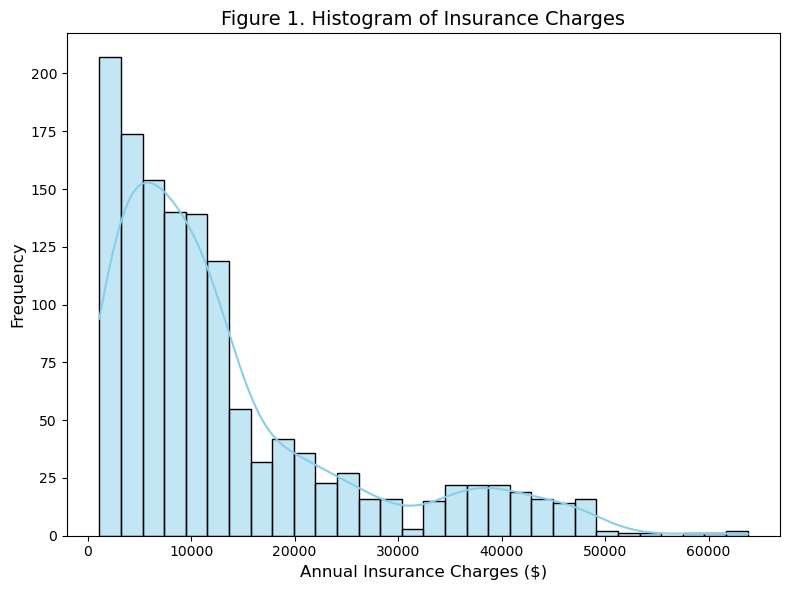

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in a DataFrame called df
# and the insurance cost column is named 'charges'

plt.figure(figsize=(8, 6))
sns.histplot(
    df['charges'],
    bins=30,
    kde=True,
    color='skyblue'
)

plt.title('Figure 1. Histogram of Insurance Charges', fontsize=14)
plt.xlabel('Annual Insurance Charges ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()
